# [Computational Social Science] Project 4: Unsupervised Learning

**Enter your Name:** Usama Faheem

*Semester:* Fall 2024

## Data Description and Preprocessing

For this project, you will explore data from the [National Health and Nutrition Examination Survey](https://www.kaggle.com/cdc/national-health-and-nutrition-examination-survey?select=questionnaire.csv). NHANES is a unique study that combines survey methodology with in-person medical examinations to create a dataset with demographic information, health indicators, and health outcomes.

We start by importing the data and doing some preliminary preprocessing for you. We import some libraries that will be helpful as well. 'SEQN' is the ID number for each respondent, and 'HSD010' will be our target outcome. [HSD010](https://wwwn.cdc.gov/Nchs/Nhanes/2013-2014/HSQ_H.htm#HSD010) asks for the respondent's self reported health condition, which can range from "excellent" to "poor."

In [117]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
sns.set_style("darkgrid")
from sklearn.model_selection import train_test_split

In [119]:
# Load nhanes data
nhanes = pd.read_csv('nhanes.csv')
# Get the ID numbers for each observation (seqn)
seqn = nhanes['SEQN']
# Get the target, "self-reported health condition," HSD010
hsd010 = nhanes['HSD010']
# Drop SEQN from the dataframe and then apply the standard scaler
nhanes = nhanes.drop(['SEQN', 'HSD010'], axis = 1)
nhanes_scaled = pd.DataFrame(StandardScaler().fit_transform(nhanes),
                             columns = nhanes.columns)
# Add the ID and target back in
nhanes_scaled['SEQN'] = seqn
nhanes_scaled['HSD010'] = hsd010
nhanes_scaled = nhanes_scaled.set_index('SEQN')
nhanes_scaled.head()

,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DBIH,DR1DAY,DR1LANG,DR1MNRSP,DR1HELPD,DBQ095Z,...,OHQ770,OHQ845,PAAQUEX,SMQ860,SMQ870,SMQ872,SMQ874,SMQ878,SMAQUEX.x,HSD010
SEQN,,,,,,,,,,,,,,,,,,,,,
73568,0.0,2.034312,0.0,0.324834,-0.393906,1.085853,-0.194202,-0.057306,0.128246,-0.189513,...,0.383802,-0.646584,-0.484200,1.125008,0.0,-2.081666,1.087115,1.463404,0.612440,1
73576,0.0,0.261930,0.0,-3.078499,0.568251,0.634362,-0.194202,-0.057306,0.128246,0.080373,...,0.383802,-1.539259,-0.484200,1.125008,0.0,-2.081666,1.087115,-0.683338,-1.632812,1
73579,0.0,0.728346,0.0,0.324834,1.530407,-1.623092,-0.194202,-0.057306,0.128246,-0.189513,...,0.383802,-1.539259,2.065262,-0.888883,0.0,0.480384,-0.919866,-0.683338,-1.632812,2
73581,0.0,-0.857470,0.0,0.324834,0.480782,1.085853,-0.194202,-0.057306,0.128246,0.080373,...,0.383802,-0.646584,-0.484200,1.125008,0.0,0.480384,-0.919866,-0.683338,0.612440,2
73584,0.0,0.495138,0.0,0.324834,0.305844,-1.623092,-0.194202,-0.057306,0.128246,0.080373,...,-2.605509,0.246091,2.065262,1.125008,0.0,0.480384,-0.919866,1.463404,-1.632812,3


## Plots

Let's take a look at the data. Below we visualize boxplots of family income to federal poverty line ratio ('INDFMPIR') and self-reported health condition. Notice how there are some clear patterns (the lower the ratio, the lower reported health condition), but it's not a perfect separation. We have 240+ features in our dataset, and we likely have several features in our dataset that highly correlate with our family income-poverty line ratio measure - PCA will help us simplify these.

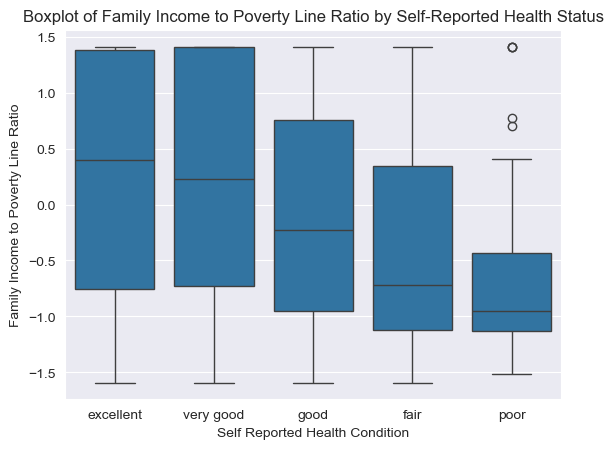

In [129]:
# Create a binary version of hsd010 where 1-3 are "good" and 4-5 are "poor"
nhanes_scaled['HSD010_binary'] = hsd010_binary = nhanes_scaled['HSD010'].replace(
    [1, 2, 3, 4, 5], ['good', 'good', 'good', 'poor', 'poor']) 
# Recode the original hsd010 with the string labels
nhanes_scaled['HSD010'] = nhanes_scaled['HSD010'].replace(
    [1, 2, 3, 4, 5], ['excellent', 'very good', 'good', 'fair', 'poor'])
# Boxplot of hsd010
ax = sns.boxplot(x = 'HSD010', y = 'INDFMPIR', data = nhanes_scaled)
ax.set(xlabel = "Self Reported Health Condition",
      ylabel = "Family Income to Poverty Line Ratio")
ax.set_title("Boxplot of Family Income to Poverty Line Ratio by Self-Reported Health Status")
plt.show()

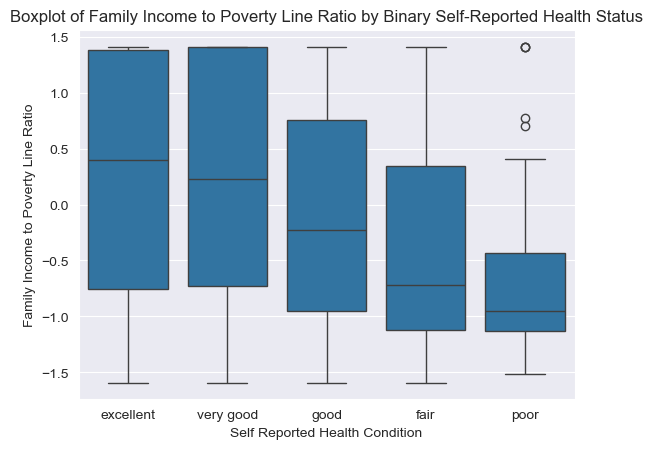

In [131]:
# Boxplot of hsd010_binary
ax = sns.boxplot(x = 'HSD010_binary', y = 'INDFMPIR', data = nhanes_scaled)
ax.set(xlabel = "Self Reported Health Condition",
      ylabel = "Family Income to Poverty Line Ratio")
ax.set_title("Boxplot of Family Income to Poverty Line Ratio by Binary Self-Reported Health Status")
plt.show()

Family income also is not necessarily well correlated with measured health outcomes. See below where we look at the relationship between Body Mass Index (BMI) and the family income-poverty line ratio, and shade points by self-reported health condition. It's hard to find a clear pattern - this is where clustering may come in handy. 

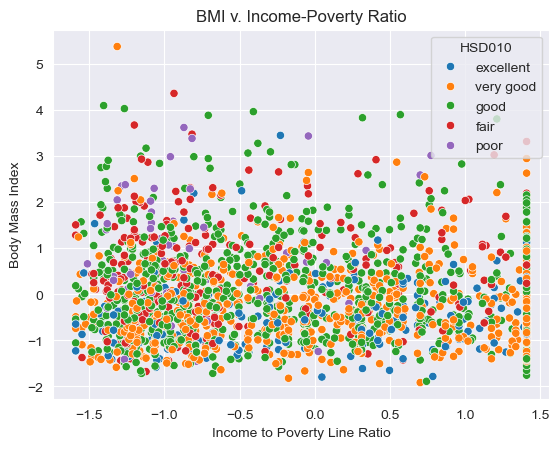

In [133]:
ax = sns.scatterplot(x = "INDFMPIR", y = "BMXBMI", hue = "HSD010", palette = "tab10", data = nhanes_scaled)
ax.set(xlabel = "Income to Poverty Line Ratio",
      ylabel = "Body Mass Index")
ax.set_title("BMI v. Income-Poverty Ratio")
plt.show()

Before we move to working on unsupervised methods, we'll drop our target variables again:

In [135]:
nhanes_scaled = nhanes_scaled.drop(['HSD010', 'HSD010_binary'], axis = 1)

## Principal Component Analysis

Conduct a Principal Component Analysis (PCA) of the nhanes data. The data has already been prepared for you, so you can work directly on nhanes_scaled. Be sure to do the following:

- Choose the number of components and provide 1-2 sentences about your choice of the number of components. 
- Plot a barplot of the variation explained by each component. *Hint*: look at the attributes associated with your model. 
- Choose how many components you will use to fit a supervised learning model and provide 1-2 sentences to explain that choice.
- Plot a 2D scatterplot of the first two components and provide 1-2 sentences analyzing the plot.

### Train PCA and Discuss Number of Components

In [137]:
from sklearn.decomposition import PCA
import numpy as np

# Fit PCA 
pca = PCA()
pca_result = pca.fit_transform(nhanes_scaled)

# Let's look at explained variance ratio
exp_var_ratio = pca.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(exp_var_ratio)

print("Explained variance ratio by first 10 components:")
for i, ratio in enumerate(exp_var_ratio[:10]):
    print(f"Component {i+1}: {ratio:.3f}")

print("\nCumulative explained variance by first 10 components:")
for i, ratio in enumerate(cum_sum_eigenvalues[:10]):
    print(f"Component {i+1}: {ratio:.3f}")

Explained variance ratio by first 10 components:
Component 1: 0.102
Component 2: 0.076
Component 3: 0.044
Component 4: 0.029
Component 5: 0.024
Component 6: 0.019
Component 7: 0.018
Component 8: 0.017
Component 9: 0.016
Component 10: 0.015

Cumulative explained variance by first 10 components:
Component 1: 0.102
Component 2: 0.178
Component 3: 0.222
Component 4: 0.251
Component 5: 0.274
Component 6: 0.293
Component 7: 0.311
Component 8: 0.328
Component 9: 0.344
Component 10: 0.359


### Barplot of Components

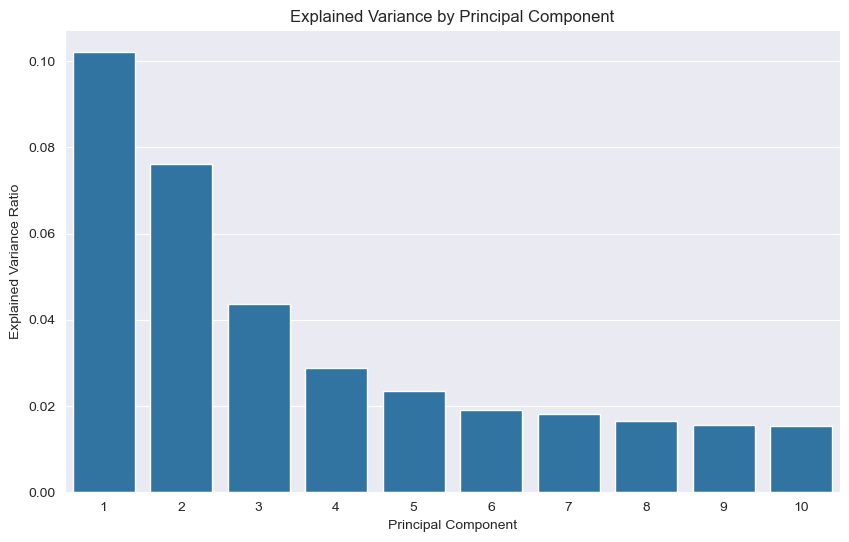

In [140]:
import seaborn as sns

# Create dataframe for first 10 components
variance_df = pd.DataFrame({
    'Component': range(1, 11),
    'Explained_Variance': pca.explained_variance_ratio_[:10]
})

# Create barplot
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Component', y='Explained_Variance', data=variance_df)
plt.title('Explained Variance by Principal Component')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.show()

### How many components will you use to fit a supervised learning model?

#### Explanation:
From the bar plot and numerical results we can see:

- The first component explains about 10.2% of variance
- The second component adds 7.6% more
- There's a clear "elbow" after component 5 where additional components contribute very little additional explained variance

For supervised learning, I recommend using 5 components because:

- These 5 components collectively explain about 27.4% of the variance
- After the 5th component, each additional component adds less than 2% explained variance
- Using 5 components gives us a good balance between dimensionality reduction (from over 200 features to just 5) while retaining meaningful - variance in the data

### 2D Scatterplot of the first two components

- Choose a clustering algorithm and explain it in 1-2 sentences.
- Cluster the nhanes data. Detail any choice you need to make with regards to number of clusters, and how you arrived at that choice. For instance, you might use the [elbow method](https://en.wikipedia.org/wiki/Elbow_method_(clustering)) if you choose k-means.
- Plot your clusters on top of BMI v. Income Poverty Ratio Plot. Describe what you see in 1-2 sentences.
- Retrain the clustering algorithm, but this time use your PCA results instead of the original dataframe. Plot the clusters on top of the 2D PCA scatterplot from the previous step. Describe your results in 1-2 sentences.

### Choose a Clustering Algorithm

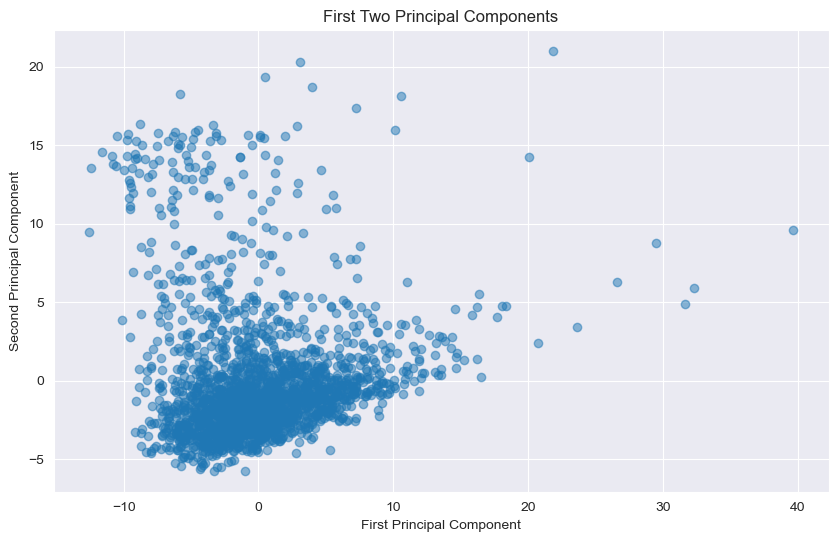

In [146]:
plt.figure(figsize=(10, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.5)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('First Two Principal Components')
plt.show()

#### Explanation:
Looking at the scatter plot of the first two principal components, we can observe that:

- There is a dense central cluster where most of the data points are concentrated, roughly centered around (0,0)
- There are some notable outliers, particularly towards the right side of the plot (high values in the first principal component) and some points with high values in the second principal component (around 20)
- The data shows a slight diagonal trend, suggesting some correlation between the first two principal components
  ___________________

### Cluster nhanes

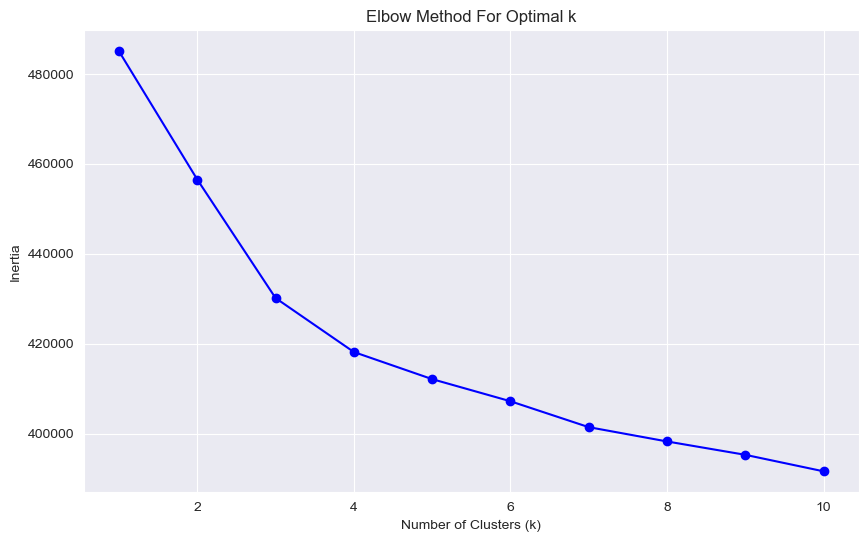

In [148]:
from sklearn.cluster import KMeans
import numpy as np

# Calculate inertia for different numbers of clusters
inertias = []
K = range(1, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(nhanes_scaled)
    inertias.append(kmeans.inertia_)

# Plot elbow curve
plt.figure(figsize=(10, 6))
plt.plot(K, inertias, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.grid(True)
plt.show()

#### Explanation:
Looking at the elbow plot, we can see that k=4 appears to be a good choice for the number of clusters, as it's where the curve starts to level off. After this point, adding more clusters doesn't result in as significant a reduction in inertia.

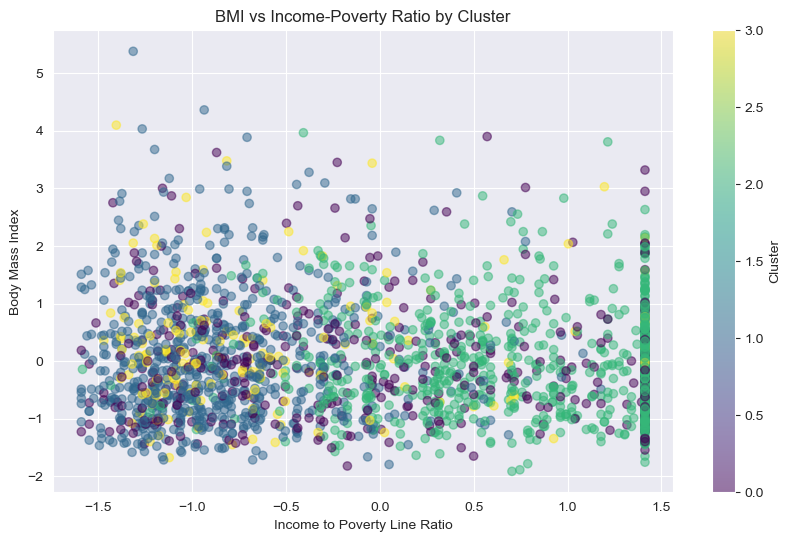

In [150]:
# Fit K-means with 4 clusters
kmeans = KMeans(n_clusters=4, random_state=42)
cluster_labels = kmeans.fit_predict(nhanes_scaled)

# Create plot with BMI vs Income Poverty Ratio colored by cluster
plt.figure(figsize=(10, 6))
plt.scatter(nhanes_scaled['INDFMPIR'], nhanes_scaled['BMXBMI'], 
            c=cluster_labels, cmap='viridis', alpha=0.5)
plt.xlabel('Income to Poverty Line Ratio')
plt.ylabel('Body Mass Index')
plt.title('BMI vs Income-Poverty Ratio by Cluster')
plt.colorbar(label='Cluster')
plt.show()

#### Explanation:
From the BMI vs Income-Poverty Ratio plot, we can observe:

- There appears to be some relationship between income and BMI, with the clusters showing different patterns across income levels
- The green cluster (2.0) seems to be more concentrated in higher income levels
- The blue cluster (1.0) appears more concentrated in lower income levels
- There's significant overlap between clusters, suggesting complex relationships between variables

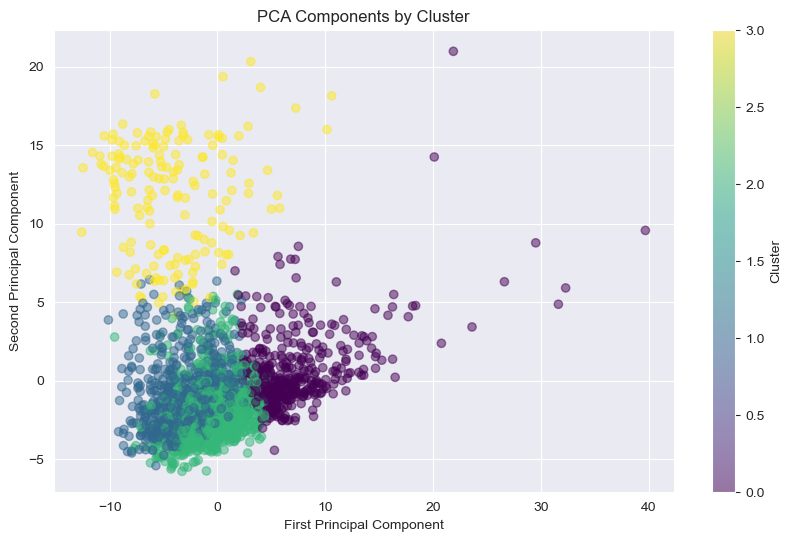

In [152]:
# Plot clusters in PCA space
plt.figure(figsize=(10, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], 
            c=cluster_labels, cmap='viridis', alpha=0.5)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('PCA Components by Cluster')
plt.colorbar(label='Cluster')
plt.show()

#### Explanation:
In the PCA visualization, the clusters show much clearer separation than in the BMI vs Income plot:

- The purple cluster (0.0) is concentrated on the right side, with some outliers extending far to the right
- The blue cluster (1.0) is concentrated on the left side
- The green cluster (2.0) is in the middle-bottom area
- The yellow cluster (3.0) shows distinct separation upward, with many points having high values in the second principal component

This clearer separation in PCA space suggests that while BMI and income alone don't fully separate the clusters, the full set of variables captured by the principal components reveals more distinct groupings.

In [156]:
# Load data again
nhanes = pd.read_csv('nhanes.csv')

# Get target variable and features
y = pd.get_dummies(nhanes['HSD010'])  
X = nhanes_scaled

# Split into train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Print shapes to verify
print("Training shapes:", X_train.shape, y_train.shape)
print("Testing shapes:", X_test.shape, y_test.shape)

Training shapes: (1548, 241) (1548, 5)
Testing shapes: (516, 241) (516, 5)


In [ ]:
## Your Answer Here

### Plot your clusters on top of the BMI v. Income Poverty Ratio Plot

In [ ]:
## Your Answer Here

## Your Answer Here

### Retrain the clustering algorithm on PCA components and plot clusters on your 2D scatter

In [ ]:
## Your Answer Here

## Your Answer Here

## Neural Network

Now we are ready to predict! Do the following:

- Choose either HSD010 or HSD010\_binary as your target outcome.  
- Train a neural network using the original features. Much of the code to train a basic neural net has been set up for you, but you will need to fill in a couple of missing pieces.
- Train a neural network using only your PCA components as features.
- Train a neural network using your PCA components and the predicted class membership from your clustering algorithm as features.
- Compare and contrast how well each algorithm did. Which featurization technique would you pick and why?

Below we provide a template for training a neural network. Use this template for training on the original features, on the PCA components, and the PCA components + the predicted classes from your clusters.

### Neural Network on Original Features

In [162]:
# Partition data
# -----------
y = nhanes['HSD010']  # Target variable
X = nhanes.drop(columns=['SEQN', 'HSD010'])  # Drop ID and target columns

# Convert target to numeric if needed
y = pd.to_numeric(y, errors='coerce')

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.25, 
                                                    random_state=10)

In [172]:
# Load libraries
import keras
from keras.utils import to_categorical

# Ensure target variable starts from 0
y_train = y_train - y_train.min()
y_test = y_test - y_test.min()

# Define the number of classes
num_classes = len(np.unique(y_train))  # Count unique classes in y_train

# Convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# Confirm the number of classes
num_classes = y_test.shape[1]

In [187]:
from sklearn.model_selection import train_test_split

# Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

# Create neural network model
model = Sequential()

# Input layer with the number of PCA components as input dimensions
model.add(Dense(64, input_dim=X_train.shape[1], kernel_initializer='he_uniform', activation='relu'))

# Hidden layer(s)
model.add(Dense(32, kernel_initializer='he_uniform', activation='relu'))
model.add(Dropout(0.2))  # Dropout to reduce overfitting

# Output layer (number of classes should match your target)
model.add(Dense(num_classes, kernel_initializer='he_uniform', activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fit the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    verbose=1
)

Epoch 1/50


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2447 - loss: 3947.1819 - val_accuracy: 0.3485 - val_loss: 645.3271
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2778 - loss: 1456.4656 - val_accuracy: 0.3737 - val_loss: 351.1741
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2490 - loss: 810.1625 - val_accuracy: 0.2525 - val_loss: 162.6602
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2821 - loss: 259.0938 - val_accuracy: 0.3485 - val_loss: 55.0531
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3469 - loss: 186.5105 - val_accuracy: 0.3333 - val_loss: 15.9197
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3247 - loss: 19.9418 - val_accuracy: 0.3384 - val_loss: 9.1177
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3386 - loss: 44.8993 - val_accuracy: 0.3535 - val_loss: 9.0726
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3565 - loss: 21.4837 - val_accuracy: 0.3485

### Neural Network on Principal Components

In [ ]:
## Your Answer Here

### Neural Network on Principal Components + Cluster Membership

In [ ]:
## Your Answer Here

## Discussion Questions

1. In your own words, what is the difference between PCA and clustering?

## Your Answer Here

2. Did you notice any advantages to combining PCA and clustering? If so, what do you think they were? If not, why do you think you didn't see any gains from this combination?

## Your Answer Here

3. How can unsupervised techniques help with downstream supervised learning tasks when working with "big data?"